# **Introducción**

En este código se entrena un modelo *Aurora* con datos de temperatura oceánica (`thetao`) filtrados para los meses de verano (JJA). Se fija un *learning rate* de `1e-5` y se ejecutan múltiples épocas de entrenamiento y validación, registrando tanto la *loss* (pérdida) de entrenamiento como la de validación, además del *RMSE* calculado en el conjunto de validación.

---

In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc").isel(time=slice(0,30))
dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset



c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 32GB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 2558)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 32GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#importar variable 
lsm=xr.open_dataset("D://Aaron//datos_mascara.nc") 

In [4]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Cargar el dataset solo con la variable que necesitas
variables = ['thetao']  # Selecciona solo 'thetao'


# Filtrar por la profundidad (limitando el número de niveles de profundidad)
dataset = dataset.isel(depth=slice(0, 10))  # Limitar a los primeros 10 niveles de profundidad
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset sin añadir coordenadas innecesarias
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset['lsm'] = lsm_interp_clean['lsm']

# Eliminar las coordenadas innecesarias si se añadieron automáticamente
coordinates_to_drop = ['number', 'step', 'surface', 'valid_time']
for coord in coordinates_to_drop:
    if coord in dataset.coords:
        dataset = dataset.drop_vars(coord)

# Verificar y ajustar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    latitude = dataset['latitude'].values
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not np.all(np.diff(latitude) < 0):
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    dataset = dataset.assign_coords(longitude=((dataset.longitude + 360) % 360))
    return dataset

# Aplicar funciones de verificación al dataset
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)

# Convertir latitudes y longitudes a tensores de Torch para su posterior uso
latitude = torch.from_numpy(dataset['latitude'].values).float()
longitude = torch.from_numpy(dataset['longitude'].values).float()

# Revisar si hay valores NaN restantes después de la interpolación y eliminarlos si es necesario
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")

# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])



In [5]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [6]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=False,autocast=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


# Dividir el conjunto de Datos

In [7]:
# Seleccionar solo los datos de verano (JJA) de cada año
dataset = dataset.where(dataset['time'].dt.month.isin([7, 8, 9]), drop=True)
# Agrupar por año y contar los veranos disponibles
years = np.unique(dataset['time'].dt.year.values)
num_years = len(years)

# Definir proporciones para entrenamiento, validación y prueba (en años completos de verano)
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
train_years = int(train_ratio * num_years)
val_years = int(val_ratio * num_years)
test_years = num_years - train_years - val_years

# Dividir el conjunto de años en entrenamiento, validación y prueba
train_years_list = years[:train_years]
val_years_list = years[train_years:train_years + val_years]
test_years_list = years[train_years + val_years:]

# Crear los conjuntos de datos de entrenamiento, validación y prueba usando veranos completos
train_dataset = dataset.sel(time=dataset['time'].dt.year.isin(train_years_list))
val_dataset = dataset.sel(time=dataset['time'].dt.year.isin(val_years_list))
test_dataset = dataset.sel(time=dataset['time'].dt.year.isin(test_years_list))


In [8]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [9]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


# Learning Rate de 1e-5

### Configuración del Optimizador y Criterios de Pérdida con Adam

In [10]:
import torch
import torch.optim as optim

# Cambiar el optimizador a Adam, recomendado en el paper
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.L1Loss(reduction='none') 

model.train()
model.configure_activation_checkpointing()




### Función RMSE para la validación

In [11]:
def rmse(predictions: np.ndarray, targets: np.ndarray, latitudes: np.ndarray) -> float:
    """
    Calcula el error cuadrático medio (RMSE) para las predicciones y los targets.

    Args:
        predictions (np.ndarray): Predicciones del modelo.
        targets (np.ndarray): Targets reales.
        latitudes (np.ndarray): Latitudes de las predicciones y los targets.

    Returns:
        float: El RMSE calculado.
    """
    # Convertir latitudes a radianes y calcular los pesos
    lat_rad = np.deg2rad(latitudes)
    weights = np.cos(lat_rad)

    # Normalizar los pesos para que su promedio sea 1
    weights_mean = np.mean(weights)
    weights_normalized = weights / weights_mean

    # Agregar dimensiones para el broadcasting
    weights_normalized = weights_normalized[np.newaxis, :, np.newaxis]

    # Calcular los errores cuadrados
    squared_errors = (predictions - targets) ** 2

    # Multiplicar por los pesos normalizados
    weighted_squared_errors = squared_errors * weights_normalized

    # Calcular el numerador: suma de los errores cuadrados ponderados
    numerator = np.sum(weighted_squared_errors)

    # Calcular el denominador: suma de los pesos
    denominator = predictions.shape[0] * predictions.shape[1] * predictions.shape[2]

    # Calcular el RMSE ponderado
    rmse_weighted = np.sqrt(numerator / denominator)

    return rmse_weighted


###  Función de entrenamiento 

In [12]:
def train(
    model, 
    train_dataset, 
    val_dataset, 
    batch_size, 
    num_epochs, 
    criterion, 
    optimizer, 
    sample_size, 
    device, 
    latitudes,
):
    """
    Entrena el modelo y calcula el RMSE en la validación.
    """
    # Generadores de batches para entrenamiento y validación
    train_generator = BatchGenerator(train_dataset, sample_size, batch_size, shuffle=True, padding=True)
    val_generator = BatchGenerator(val_dataset, sample_size, batch_size, shuffle=False, padding=False)

    # Listas para almacenar pérdidas y RMSE
    train_losses = []
    val_losses = []
    val_rmses = []

    # Inicializar el escalador para AMP
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_batches = 0

        for batch, batch_target in tqdm(train_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Train"): 
            optimizer.zero_grad()

            if getattr(batch.metadata, 'is_padding', False):
                continue

            # Obtener el target y moverlo al dispositivo
            target = batch_target.surf_vars['thetao'].to(device)  # Shape: (batch_size, 1, lat, lon)

            with autocast(device_type=device.type):
                # Obtener las predicciones del modelo
                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']  # Shape: (batch_size, 1, lat, lon)

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch
                loss = loss_per_sample.mean()

            # Backpropagación
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Acumular la pérdida
            train_loss += loss.item()
            total_batches += 1

            


        # Promediar la pérdida del entrenamiento
        if total_batches > 0:
            average_train_loss = train_loss / total_batches
            train_losses.append(average_train_loss)
        else:
            train_losses.append(0)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}")

        # Validación
        model.eval()
        val_loss = 0.0
        total_val_batches = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch, batch_target in tqdm(val_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                if getattr(batch.metadata, 'is_padding', False):
                    continue

                target = batch_target.surf_vars['thetao'].to(device)

                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch
                loss = loss_per_sample.mean()

                val_loss += loss.item()
                total_val_batches += 1

                # Recopilar predicciones y targets para calcular el RMSE
                val_predictions.append(output_tensor.detach().cpu().numpy())
                val_targets.append(target.detach().cpu().numpy())

                


        # Promediar la pérdida de validación
        if total_val_batches > 0:
            average_val_loss = val_loss / total_val_batches
            val_losses.append(average_val_loss)
        else:
            val_losses.append(0)
        
        # Calcular el RMSE sobre el conjunto de validación
        if val_predictions and val_targets:
            val_predictions = np.concatenate(val_predictions, axis=0)  # Shape: (num_samples, 1, lat, lon)
            val_targets = np.concatenate(val_targets, axis=0)          # Shape: (num_samples, 1, lat, lon)

            # Eliminar la dimensión singleton
            val_predictions = val_predictions.squeeze(axis=1)  # Shape: (num_samples, lat, lon)
            val_targets = val_targets.squeeze(axis=1)          # Shape: (num_samples, lat, lon)

            # Calcular el RMSE
            val_rmse = rmse(val_predictions, val_targets, latitudes)
            val_rmses.append(val_rmse)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, Validation RMSE: {val_rmse:.6f}")
        else:
            val_rmses.append(0)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, No se pudo calcular el RMSE.")

    return train_losses, val_losses, val_rmses


In [13]:
# Parámetros para el entrenamiento
batch_size = 3
sample_size = 3
num_epochs = 30

# Obtener las latitudes como array de NumPy
latitudes = dataset['latitude'].values  # Forma: (lat,)

# Ejecutar el entrenamiento con validación y cálculo de RMSE
train_losses, val_losses, val_rmses = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer,
    sample_size=sample_size,
    device=device,
    latitudes=latitudes
)




Epoch 1/30 - Train: 0it [00:00, ?it/s]c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)
c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\torch\utils\checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Epoch 1/30 - Train: 122it [1:26:25, 42.51s/it]


Epoch 1/30, Train Loss: 0.300196


Epoch 1/30 - Validation: 30it [05:26, 10.88s/it]


Epoch 1/30, Validation Loss: 0.158098, Validation RMSE: 0.236890


Epoch 2/30 - Train: 122it [1:24:21, 41.48s/it]


Epoch 2/30, Train Loss: 0.163017


Epoch 2/30 - Validation: 30it [05:19, 10.63s/it]


Epoch 2/30, Validation Loss: 0.127389, Validation RMSE: 0.184226


Epoch 3/30 - Train: 122it [1:24:20, 41.48s/it]


Epoch 3/30, Train Loss: 0.148345


Epoch 3/30 - Validation: 30it [05:13, 10.45s/it]


Epoch 3/30, Validation Loss: 0.133842, Validation RMSE: 0.175902


Epoch 4/30 - Train: 122it [1:24:27, 41.54s/it]


Epoch 4/30, Train Loss: 0.142423


Epoch 4/30 - Validation: 30it [05:13, 10.45s/it]


Epoch 4/30, Validation Loss: 0.121183, Validation RMSE: 0.158503


Epoch 5/30 - Train: 122it [1:24:28, 41.55s/it]


Epoch 5/30, Train Loss: 0.137798


Epoch 5/30 - Validation: 30it [05:13, 10.44s/it]


Epoch 5/30, Validation Loss: 0.116955, Validation RMSE: 0.151916


Epoch 6/30 - Train: 122it [1:24:30, 41.56s/it]


Epoch 6/30, Train Loss: 0.134881


Epoch 6/30 - Validation: 30it [05:13, 10.46s/it]


Epoch 6/30, Validation Loss: 0.116503, Validation RMSE: 0.149257


Epoch 7/30 - Train: 122it [1:24:28, 41.55s/it]


Epoch 7/30, Train Loss: 0.132770


Epoch 7/30 - Validation: 30it [05:13, 10.44s/it]


Epoch 7/30, Validation Loss: 0.120403, Validation RMSE: 0.151618


Epoch 8/30 - Train: 122it [1:24:25, 41.52s/it]


Epoch 8/30, Train Loss: 0.131367


Epoch 8/30 - Validation: 30it [05:13, 10.44s/it]


Epoch 8/30, Validation Loss: 0.114945, Validation RMSE: 0.145215


Epoch 9/30 - Train: 122it [1:24:27, 41.54s/it]


Epoch 9/30, Train Loss: 0.130730


Epoch 9/30 - Validation: 30it [05:13, 10.45s/it]


Epoch 9/30, Validation Loss: 0.111249, Validation RMSE: 0.140797


Epoch 10/30 - Train: 122it [1:24:29, 41.55s/it]


Epoch 10/30, Train Loss: 0.129736


Epoch 10/30 - Validation: 30it [05:13, 10.45s/it]


Epoch 10/30, Validation Loss: 0.110622, Validation RMSE: 0.138218


Epoch 11/30 - Train: 122it [1:24:32, 41.58s/it]


Epoch 11/30, Train Loss: 0.129699


Epoch 11/30 - Validation: 30it [05:13, 10.45s/it]


Epoch 11/30, Validation Loss: 0.102155, Validation RMSE: 0.131548


Epoch 12/30 - Train: 122it [1:24:29, 41.55s/it]


Epoch 12/30, Train Loss: 0.129607


Epoch 12/30 - Validation: 30it [05:13, 10.45s/it]


Epoch 12/30, Validation Loss: 0.102899, Validation RMSE: 0.130622


Epoch 13/30 - Train: 122it [1:24:33, 41.58s/it]


Epoch 13/30, Train Loss: 0.129738


Epoch 13/30 - Validation: 30it [05:13, 10.47s/it]


Epoch 13/30, Validation Loss: 0.099919, Validation RMSE: 0.129726


Epoch 14/30 - Train: 122it [1:24:34, 41.60s/it]


Epoch 14/30, Train Loss: 0.129004


Epoch 14/30 - Validation: 30it [05:13, 10.46s/it]


Epoch 14/30, Validation Loss: 0.099368, Validation RMSE: 0.128288


Epoch 15/30 - Train: 122it [1:24:40, 41.64s/it]


Epoch 15/30, Train Loss: 0.128316


Epoch 15/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 15/30, Validation Loss: 0.105391, Validation RMSE: 0.133992


Epoch 16/30 - Train: 122it [1:24:37, 41.62s/it]


Epoch 16/30, Train Loss: 0.128004


Epoch 16/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 16/30, Validation Loss: 0.114923, Validation RMSE: 0.143678


Epoch 17/30 - Train: 122it [1:24:36, 41.61s/it]


Epoch 17/30, Train Loss: 0.127897


Epoch 17/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 17/30, Validation Loss: 0.113262, Validation RMSE: 0.141308


Epoch 18/30 - Train: 122it [1:24:42, 41.66s/it]


Epoch 18/30, Train Loss: 0.127202


Epoch 18/30 - Validation: 30it [05:14, 10.48s/it]


Epoch 18/30, Validation Loss: 0.115318, Validation RMSE: 0.142596


Epoch 19/30 - Train: 122it [1:24:39, 41.64s/it]


Epoch 19/30, Train Loss: 0.127052


Epoch 19/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 19/30, Validation Loss: 0.114995, Validation RMSE: 0.141822


Epoch 20/30 - Train: 122it [1:24:44, 41.68s/it]


Epoch 20/30, Train Loss: 0.126385


Epoch 20/30 - Validation: 30it [05:14, 10.48s/it]


Epoch 20/30, Validation Loss: 0.118001, Validation RMSE: 0.144186


Epoch 21/30 - Train: 122it [1:24:45, 41.69s/it]


Epoch 21/30, Train Loss: 0.126361


Epoch 21/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 21/30, Validation Loss: 0.114850, Validation RMSE: 0.140449


Epoch 22/30 - Train: 122it [1:24:40, 41.64s/it]


Epoch 22/30, Train Loss: 0.125731


Epoch 22/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 22/30, Validation Loss: 0.113898, Validation RMSE: 0.138771


Epoch 23/30 - Train: 122it [1:24:40, 41.65s/it]


Epoch 23/30, Train Loss: 0.125625


Epoch 23/30 - Validation: 30it [05:14, 10.47s/it]


Epoch 23/30, Validation Loss: 0.111657, Validation RMSE: 0.136485


Epoch 24/30 - Train: 122it [1:24:42, 41.66s/it]


Epoch 24/30, Train Loss: 0.125658


Epoch 24/30 - Validation: 30it [05:14, 10.49s/it]


Epoch 24/30, Validation Loss: 0.108411, Validation RMSE: 0.134085


Epoch 25/30 - Train: 122it [1:24:45, 41.69s/it]


Epoch 25/30, Train Loss: 0.124835


Epoch 25/30 - Validation: 30it [05:14, 10.48s/it]


Epoch 25/30, Validation Loss: 0.113198, Validation RMSE: 0.139422


Epoch 26/30 - Train: 122it [1:24:46, 41.69s/it]


Epoch 26/30, Train Loss: 0.125074


Epoch 26/30 - Validation: 30it [05:14, 10.48s/it]


Epoch 26/30, Validation Loss: 0.109435, Validation RMSE: 0.135460


Epoch 27/30 - Train: 122it [1:24:59, 41.80s/it]


Epoch 27/30, Train Loss: 0.124426


Epoch 27/30 - Validation: 30it [05:15, 10.52s/it]


Epoch 27/30, Validation Loss: 0.106593, Validation RMSE: 0.133481


Epoch 28/30 - Train: 122it [1:24:52, 41.74s/it]


Epoch 28/30, Train Loss: 0.124205


Epoch 28/30 - Validation: 30it [05:15, 10.51s/it]


Epoch 28/30, Validation Loss: 0.104713, Validation RMSE: 0.133042


Epoch 29/30 - Train: 122it [1:25:04, 41.84s/it]


Epoch 29/30, Train Loss: 0.124018


Epoch 29/30 - Validation: 30it [05:15, 10.53s/it]


Epoch 29/30, Validation Loss: 0.107536, Validation RMSE: 0.134855


Epoch 30/30 - Train: 122it [1:25:05, 41.85s/it]


Epoch 30/30, Train Loss: 0.123592


Epoch 30/30 - Validation: 30it [05:22, 10.74s/it]

Epoch 30/30, Validation Loss: 0.110537, Validation RMSE: 0.137038


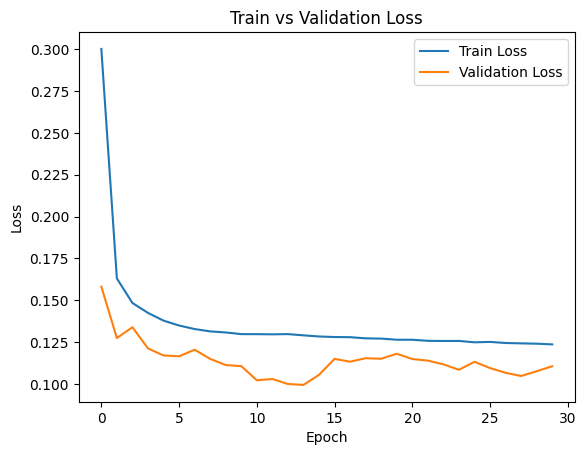

In [14]:
# Graficar las pérdidas
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# **Resultados del entrenamiento**

Durante el entrenamiento, se observa cómo la *Train Loss* decrece de manera progresiva mientras aumentan las épocas, indicando que el modelo va ajustándose a los datos de entrenamiento. A su vez, la *Validation Loss* y el *RMSE* permiten evaluar el rendimiento en datos que el modelo no ha visto directamente.  
A grandes rasgos, se aprecian las siguientes tendencias:

- **Train Loss**: Comienza alrededor de `0.30` y decrece hasta aproximarse a valores cercanos a `0.12`–`0.13`.
- **Validation Loss**: Inicialmente arranca en `0.158` y desciende hasta la zona de `0.10`–`0.11`, evidenciando una mejora continua.
- **Validation RMSE**: Inicia cerca de `0.2369` y, con el paso de las épocas, desciende hasta valores próximos a `0.13`–`0.14`, mostrándonos que el modelo reduce su error medio en las predicciones sobre la validación.

El gráfico final de *Train vs Validation Loss* refleja cómo, tras varias épocas, la validación y el entrenamiento presentan tendencias coherentes sin una divergencia excesiva, lo que apunta a una generalización razonable.

---

# **Conclusión**

En conclusión, el entrenamiento con un *learning rate* de `1e-5` y la configuración propuesta (filtrado en meses de verano y limitación de profundidad) ha llevado a que el modelo *Aurora* aprenda progresivamente a predecir `thetao` con una disminución simultánea de las pérdidas y el RMSE. Estos resultados sugieren que el modelo está logrando un buen ajuste y un desempeño estable en validación, y deja abierta la posibilidad de seguir afinando hiperparámetros o incrementando épocas para obtener mejoras adicionales.